In [763]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

In [764]:
cwd = os.getcwd()
# Read the data
used_dataset_dir = os.path.join(cwd, 'separated_merged')
cleaned_dataset_dir = os.path.join(cwd, 'cleaned_data')

# Read the data
weather_df_2022 = pd.read_csv(os.path.join(used_dataset_dir, 'weather_2022.csv'))
tidal_df_2022 = pd.read_csv(os.path.join(used_dataset_dir, 'tidal_daily_average_22.csv'))
tidal_df_2020 = pd.read_csv(os.path.join(used_dataset_dir, 'tidal_daily_average_20.csv'))
weather_df_2020 = pd.read_csv(os.path.join(used_dataset_dir, 'weather_2020.csv'))


In [765]:
# Ensure the 'Date' column is in datetime format

weather_df_2022.rename(columns={'Time (UTC)': 'Date'}, inplace=True)
weather_df_2020.rename(columns={'Tanggal': 'Date'}, inplace=True)
tidal_df_2022.drop(columns=['Time (UTC)'], inplace=True)
tidal_df_2020.drop(columns=['Time (UTC)'], inplace=True)

# convert Date data weather 2020 menjadi  YYYY-MM-DD
weather_df_2020['Date'] = pd.to_datetime(weather_df_2020['Date'], format='%d-%m-%Y')

weather_df_2022['Date'] = pd.to_datetime(weather_df_2022['Date'], errors='coerce')
weather_df_2020['Date'] = pd.to_datetime(weather_df_2020['Date'], errors='coerce')
tidal_df_2022['Date'] = pd.to_datetime(tidal_df_2022['Date'], errors='coerce')
tidal_df_2020['Date'] = pd.to_datetime(tidal_df_2020['Date'], errors='coerce')

# Merge weather_df_2022 and weather_df_2020
merged_weather_df = pd.concat([weather_df_2022, weather_df_2020], ignore_index=True)
merged_tidal_df = pd.concat([tidal_df_2022, tidal_df_2020], ignore_index=True)


# merge weather and tidal data
merged_df = pd.merge(merged_weather_df, merged_tidal_df, on='Date', how='inner')
display(merged_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     731 non-null    datetime64[ns]
 1   Tn       731 non-null    float64       
 2   Tx       731 non-null    float64       
 3   Tavg     731 non-null    float64       
 4   RH_avg   731 non-null    float64       
 5   RR       731 non-null    float64       
 6   ss       731 non-null    object        
 7   ff_x     730 non-null    object        
 8   ddd_x    718 non-null    object        
 9   ff_avg   696 non-null    object        
 10  ddd_car  295 non-null    object        
 11  rad(m)   731 non-null    float64       
dtypes: datetime64[ns](1), float64(6), object(5)
memory usage: 68.7+ KB


None

In [766]:

merged_data_sorted = merged_df.sort_values(by='Date')
merged_data_sorted.reset_index(drop=True, inplace=True)
display(merged_data_sorted.head())
display(merged_data_sorted.tail())
# Show the amount of merged_data_sorted
print(f'The number of rows in merged_data_sorted: {merged_data_sorted.shape[0]}')
print(f'The number of columns in merged_data_sorted: {merged_data_sorted.shape[1]}')

,Date,Tn,Tx,Tavg,RH_avg,RR,ss,ff_x,ddd_x,ff_avg,ddd_car,rad(m)
0,2020-01-01,25.2,32.0,27.0,82.0,16.5,6.5,7,300,3,W,-0.221338
1,2020-01-02,25.6,31.0,27.9,78.0,5.2,3.5,8,270,4,W,-0.200959
2,2020-01-03,25.3,31.5,27.6,82.0,1.5,5.9,10,280,6,W,-0.158172
3,2020-01-04,26.5,30.5,27.9,77.0,1.7,4.6,12,260,8,W,-0.125176
4,2020-01-05,25.6,31.3,28.6,81.0,8.1,8,260,6,W,NaN,-0.127169


,Date,Tn,Tx,Tavg,RH_avg,RR,ss,ff_x,ddd_x,ff_avg,ddd_car,rad(m)
726,2022-12-27,25.5,29.5,27.5,83.0,6.0,1.2,9.0,270.0,6.0,NaN,-0.024320
727,2022-12-28,24.5,29.1,26.9,84.0,2.3,0.0,9.0,270.0,5.0,NaN,-0.030015
728,2022-12-29,24.0,30.1,27.0,84.0,35.6,3.2,8.0,260.0,4.0,NaN,0.005127
729,2022-12-30,25.9,30.0,27.6,83.0,1.0,4.9,7.0,310.0,3.0,NaN,-0.828327
730,2022-12-31,24.9,32.2,27.7,83.0,0.0,0.6,7.0,280.0,3.0,NaN,-0.401817


The number of rows in merged_data_sorted: 731
The number of columns in merged_data_sorted: 12


In [767]:
# Check for null values before processing
display("Initial null values:")
display(merged_data_sorted.isnull().sum())

# Check the data types to identify 'object' columns
# print("Data types:")
# display(merged_data_sorted.dtypes)

# List of object columns that might need conversion
object_columns = ['ss', 'ff_x', 'ddd_x', 'ff_avg']

# Convert these columns to numeric, coerce invalid values to NaN
for col in object_columns:
    merged_data_sorted[col] = pd.to_numeric(merged_data_sorted[col], errors='coerce')

# Now check for null values after conversion
# print("Null values after conversion:")
# display(merged_data_sorted.isnull().sum())

# Select only numeric columns for 'fillna'
numeric_columns = merged_data_sorted.select_dtypes(include=['float64', 'int64']).columns

# Replace NaN values in numeric columns with their mean
merged_data_sorted[numeric_columns] = merged_data_sorted[numeric_columns].fillna(merged_data_sorted[numeric_columns].mean())

# Drop the 'ddd_car' column as it is not needed
merged_data_sorted.drop(columns=['ddd_car'], inplace=True)

# Check if there are still any NaN values
print("Final null values after filling:")
display(merged_data_sorted.isnull().sum())


'Initial null values:'

Date         0
Tn           0
Tx           0
Tavg         0
RH_avg       0
RR           0
ss           0
ff_x         1
ddd_x       13
ff_avg      35
ddd_car    436
rad(m)       0
dtype: int64

Final null values after filling:


Date      0
Tn        0
Tx        0
Tavg      0
RH_avg    0
RR        0
ss        0
ff_x      0
ddd_x     0
ff_avg    0
rad(m)    0
dtype: int64

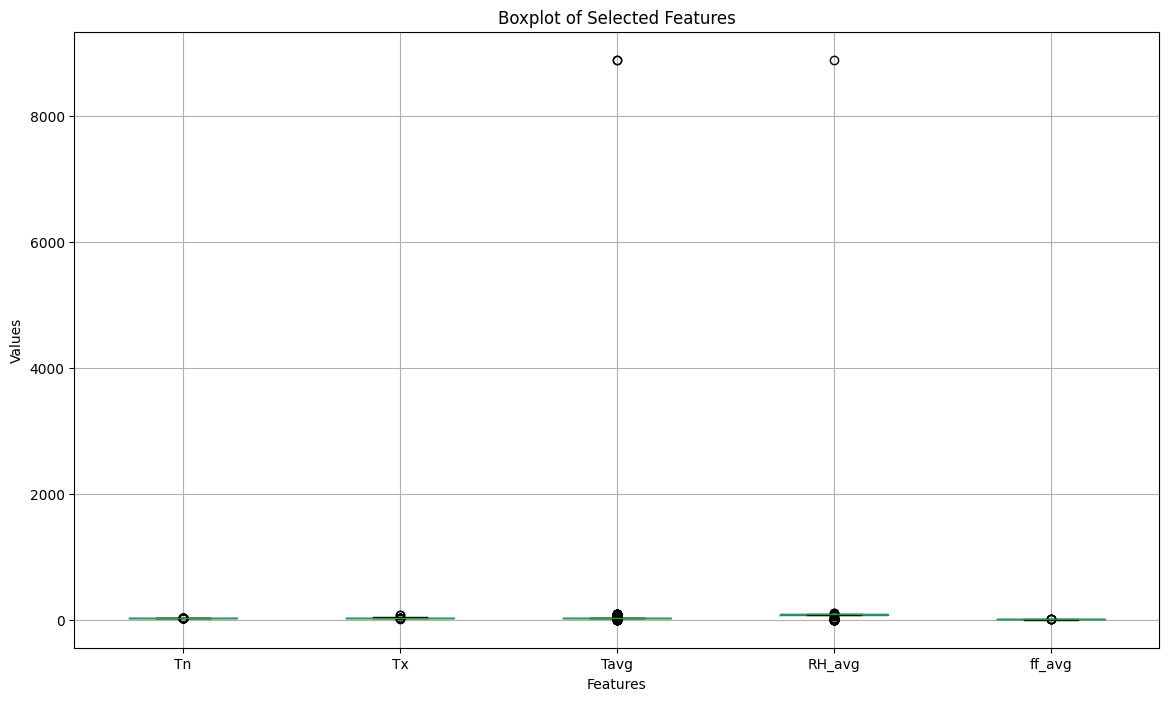

In [768]:
# Select the features to check for outliers
features_to_check = ['Tn', 'Tx', 'Tavg', 'RH_avg', 'ff_avg']

# Create a boxplot for each feature
plt.figure(figsize=(14, 8))
merged_data_sorted[features_to_check].boxplot()
plt.title('Boxplot of Selected Features')
plt.xlabel('Features')
plt.ylabel('Values')
plt.show()

In [769]:
def calculate_z_scores_and_outliers(dataframe, numeric_columns):
    # Menghitung z-score untuk kolom numerik
    z_scores = dataframe[numeric_columns].apply(zscore)

    # Tentukan ambang batas untuk outlier
    outliers = (z_scores > 3) | (z_scores < -3)

    return outliers

def detect_outliers(dataframe, numeric_columns):
    Q1 = dataframe[numeric_columns].quantile(0.25)
    Q3 = dataframe[numeric_columns].quantile(0.75)
    IQR = Q3 - Q1

    # Outlier: nilai yang lebih kecil dari (Q1 - 1.5 * IQR) atau lebih besar dari (Q3 + 1.5 * IQR)
    outliers = (dataframe[numeric_columns] < (Q1 - 1.5 * IQR)) | (dataframe[numeric_columns] > (Q3 + 1.5 * IQR))

    return outliers


# Call the function
outliers_z = calculate_z_scores_and_outliers(merged_data_sorted, numeric_columns)

# Call the function
outliers = detect_outliers(merged_data_sorted, numeric_columns)

print("Outliers using z-scores:")
display(outliers_z.sum())
print("Outliers using IQR:")
display(outliers.sum())

Outliers using z-scores:


Tn        19
Tx         3
Tavg       2
RH_avg     1
RR        73
ss        20
ff_x      14
ddd_x      0
ff_avg     9
rad(m)     4
dtype: int64

Outliers using IQR:


Tn         52
Tx         12
Tavg       63
RH_avg     62
RR        123
ss         27
ff_x       71
ddd_x       0
ff_avg      5
rad(m)     10
dtype: int64

Fix Outlier

In [770]:
Q1 = merged_data_sorted[numeric_columns].quantile(0.25)
Q3 = merged_data_sorted[numeric_columns].quantile(0.75)
IQR = Q3 - Q1


# Tentukan threshold IQR yang lebih ketat
threshold = 3  # atau 2.5

# Tentukan batas bawah dan atas untuk tiap kolom
lower_bound = Q1 - threshold * IQR
upper_bound = Q3 + threshold * IQR

# Ganti outlier dengan median
for column in numeric_columns:
    median = merged_data_sorted[column].median()
    
    # Cek apakah nilai lebih kecil dari batas bawah atau lebih besar dari batas atas
    outliers_mask = (merged_data_sorted[column] < lower_bound[column]) | (merged_data_sorted[column] > upper_bound[column])
    
    # Ganti outlier dengan median
    merged_data_sorted[column] = merged_data_sorted[column].where(~outliers_mask, median)

# Tampilkan data setelah penggantian
outliers_z = calculate_z_scores_and_outliers(merged_data_sorted, numeric_columns)
outliers = detect_outliers(merged_data_sorted, numeric_columns)

print("Outliers using z-scores:")
display(outliers_z.sum())
print("Outliers using IQR:")
display(outliers.sum())


Outliers using z-scores:


Tn        11
Tx         6
Tavg       5
RH_avg     7
RR        26
ss         0
ff_x       7
ddd_x      0
ff_avg     9
rad(m)     4
dtype: int64

Outliers using IQR:


Tn         28
Tx         11
Tavg       10
RH_avg      8
RR         72
ss          0
ff_x      104
ddd_x       0
ff_avg      5
rad(m)      9
dtype: int64

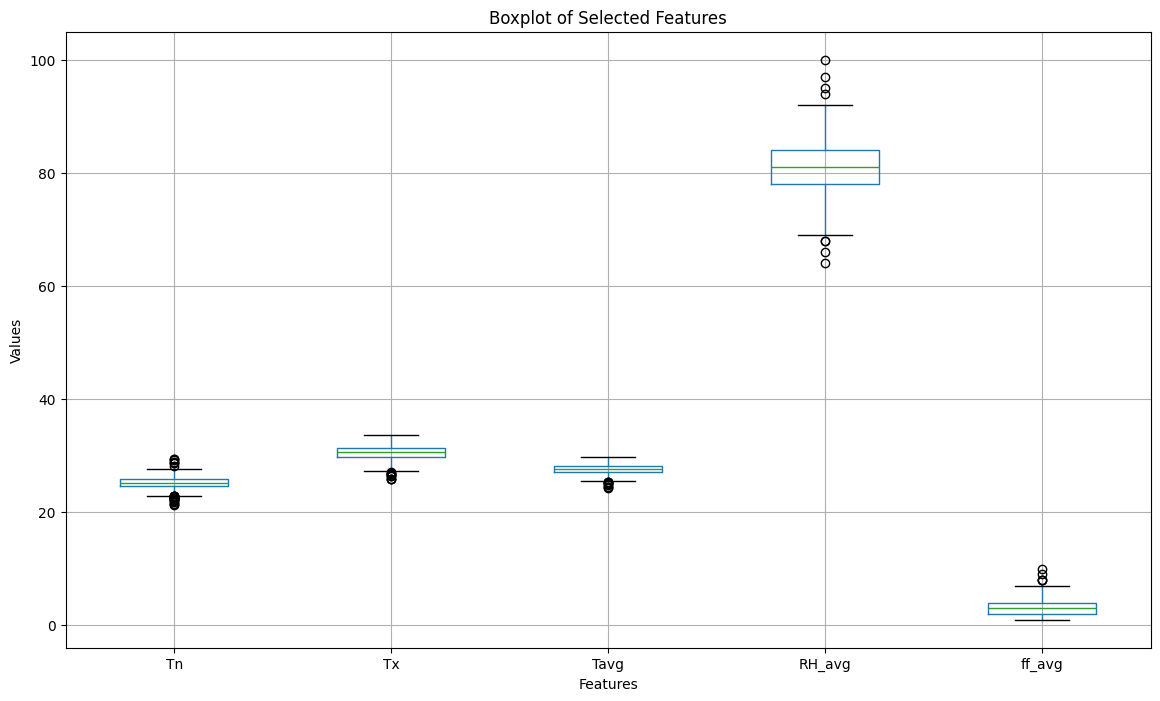

In [771]:
# Select the features to check for outliers
features_to_check = ['Tn', 'Tx', 'Tavg', 'RH_avg', 'ff_avg']

# Create a boxplot for each feature
plt.figure(figsize=(14, 8))
merged_data_sorted[features_to_check].boxplot()
plt.title('Boxplot of Selected Features')
plt.xlabel('Features')
plt.ylabel('Values')
plt.show()

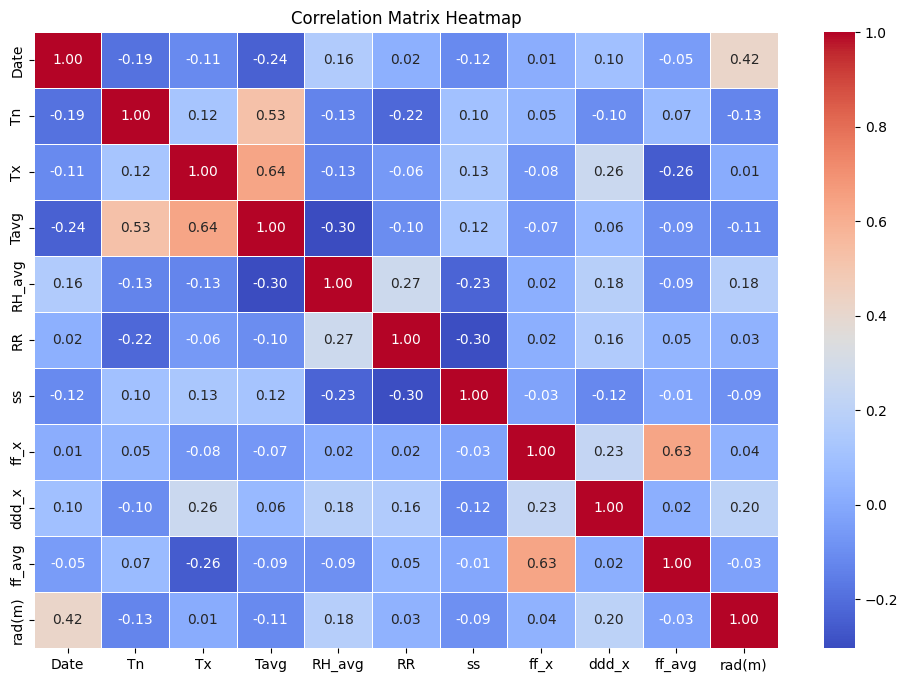

In [772]:
# Calculate the correlation matrix
correlation_matrix = merged_data_sorted.corr()

# Set the size of the plot
plt.figure(figsize=(12, 8))

# Create a heatmap to visualize the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Set the title of the heatmap
plt.title('Correlation Matrix Heatmap')

# Display the heatmap
plt.show()

Cleaned Merged


In [773]:
# Save the merged data to a new CSV file
merged_data_sorted.to_csv(os.path.join(cleaned_dataset_dir, 'cleaned_data_2020_2022.csv'), index=False)